# Intersubject correlation

(1) set up environment

In [1]:
%matplotlib inline 
import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

(2) Esimate the average functional activation in region-of-interest

In [2]:
os.chdir ('/project/3013104.01')
os.getcwd()

'/project/3013104.01'

Download the Schaefer 2018 atlas: 2mm, 7 networks, 300 parcels
https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


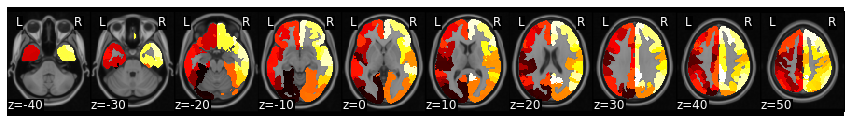

In [3]:
mask = Brain_Data('analysis/Schaefer2018_300Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

Create a file list of images to analyze

In [4]:
os.chdir('/project/3013104.01/')

# Create a list of all fMRI data and store in a variable called 'file_list'
data_dir = 'pulled-data-MRI/'

# Use glob to find all files matching the pattern
file_list = glob.glob(os.path.join(data_dir, 'subject-*/mri_movietask_*/filtered_func_data_clean_MNI.nii.gz'))
#file_list = glob.glob('subject-*/mri_movietask_*/filtered_func_data_clean_MNI.nii.gz')

# Iterate over the matched files
for file_path in file_list:
    print(file_path)

pulled-data-MRI/subject-0126/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0126/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0201/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0201/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0201/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0139/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0139/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0139/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0186/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0186/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0186/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0116/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0116

Estimate the average activity within each ROI into a separate csv file for each participant.

In [32]:
# List of directories to check
directories = glob.glob(os.path.join(data_dir, 'subject-*/mri_movietask_*'))

# String to match in filenames
string_to_match = '_Average_ROI_300.csv'

for directory in directories:
    if any(filename for filename in os.listdir(directory) if string_to_match in filename):
        print(f"A file matching '{string_to_match}' found in {directory}. Skipping...")
        continue

    # Run script logic here for the directory if no matching file is found
    print(f"No file matching '{string_to_match}' found in {directory}. Proceeding...")

    # Write out the average activity within each ROI into a separate csv file for each participant
    for file_path in file_list:
        data = Brain_Data(file_path)
        roi = data.extract_roi(mask)
        pd.DataFrame(roi.T).to_csv(os.path.join(os.path.dirname(file_path), f"_Average_ROI_300.csv" ), index=False)

A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0126/mri_movietask_2. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0126/mri_movietask_3. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0201/mri_movietask_1. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0201/mri_movietask_2. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0201/mri_movietask_3. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0139/mri_movietask_3. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0139/mri_movietask_1. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0139/mri_movietask_2. Skipping...
A file matching '_Average_ROI_300.csv' found in pulled-data-MRI/subject-0186/mri_movietask_1. Skipping...
A file matching '_Average_ROI_300.csv' found i

KeyboardInterrupt: 

If the process times out and stops prematurely, then check which subject sub-directories already have the required file

In [5]:
# Create list of all subject sessions that have the average ROI 300 estimations
data_dir = 'pulled-data-MRI/'

# Use glob to find all files matching the pattern
file_list_completed = glob.glob(os.path.join(data_dir, 'subject-*/mri_movietask_*/_Average_ROI_300.csv'))

file_list_updated = []

for filename in file_list_completed:
    new_filename = filename.replace("_Average_ROI_300.csv", "filtered_func_data_clean_MNI.nii.gz")
    file_list_updated.append(new_filename)

for file in file_list_updated:
    print(file)

pulled-data-MRI/subject-0126/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0126/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0201/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0201/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0201/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0139/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0139/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0139/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0186/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0186/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0186/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0116/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0116

Remove filepaths from the list that have already been analyzed, creating a new, smaller list

In [6]:
# Convert the lists to sets
file_set = set(file_list)
completed_set = set(file_list_updated)

# Remove completed files from the original set
incomplete_set = file_set - completed_set

# Convert the updated set back to a list
file_list_incomplete = list(incomplete_set)

# Print the updated list
for file in file_list_incomplete:
    print(file)

pulled-data-MRI/subject-0214/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0158/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0010/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0030/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0182/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0226/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0005/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0067/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0081/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0168/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0209/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0077/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
pulled-data-MRI/subject-0223

Run the script again

In [7]:
# Write out the average activity within each ROI into a separate csv file for each participant
for file_path in file_list_incomplete:
    data = Brain_Data(file_path)
    roi = data.extract_roi(mask)
    pd.DataFrame(roi.T).to_csv(os.path.join(os.path.dirname(file_path), f"_Average_ROI_300.csv" ), index=False)

Accidentally did not include the subject name into the filename, so rename the csv files

In [20]:
# Create list of all subject sessions that have the average ROI 300 estimations
data_dir = 'pulled-data-MRI/'

# Use glob to find all files matching the pattern
file_list_completed = glob.glob(os.path.join(data_dir, 'subject-*/mri_movietask_*/_Average_ROI_300.csv'))

for file in file_list_completed:
    print(file)

pulled-data-MRI/subject-0126/mri_movietask_2/_Average_ROI_300.csv
pulled-data-MRI/subject-0126/mri_movietask_3/_Average_ROI_300.csv
pulled-data-MRI/subject-0201/mri_movietask_1/_Average_ROI_300.csv
pulled-data-MRI/subject-0201/mri_movietask_2/_Average_ROI_300.csv
pulled-data-MRI/subject-0201/mri_movietask_3/_Average_ROI_300.csv
pulled-data-MRI/subject-0139/mri_movietask_3/_Average_ROI_300.csv
pulled-data-MRI/subject-0139/mri_movietask_1/_Average_ROI_300.csv
pulled-data-MRI/subject-0139/mri_movietask_2/_Average_ROI_300.csv
pulled-data-MRI/subject-0186/mri_movietask_1/_Average_ROI_300.csv
pulled-data-MRI/subject-0186/mri_movietask_2/_Average_ROI_300.csv
pulled-data-MRI/subject-0186/mri_movietask_3/_Average_ROI_300.csv
pulled-data-MRI/subject-0116/mri_movietask_2/_Average_ROI_300.csv
pulled-data-MRI/subject-0116/mri_movietask_3/_Average_ROI_300.csv
pulled-data-MRI/subject-0180/mri_movietask_1/_Average_ROI_300.csv
pulled-data-MRI/subject-0180/mri_movietask_2/_Average_ROI_300.csv
pulled-dat

In [21]:
for file_path in file_list_completed:
    directory, file_name = os.path.split(file_path)
    new_file_name = os.path.join(directory, directory.replace('/', '_') + '_' + file_name)
    os.rename(file_path, new_file_name)
    print(f"Renamed {file_path} to {new_file_name}")

Renamed pulled-data-MRI/subject-0126/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0126/mri_movietask_2/pulled-data-MRI_subject-0126_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0126/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0126/mri_movietask_3/pulled-data-MRI_subject-0126_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0201/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0201/mri_movietask_1/pulled-data-MRI_subject-0201_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0201/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0201/mri_movietask_2/pulled-data-MRI_subject-0201_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0201/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0201/mri_movietask_3/pulled-data-MRI_subject-0201_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0139/mri_movietask_3/_Averag

Renamed pulled-data-MRI/subject-0013/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0013/mri_movietask_2/pulled-data-MRI_subject-0013_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0013/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0013/mri_movietask_3/pulled-data-MRI_subject-0013_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0021/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0021/mri_movietask_1/pulled-data-MRI_subject-0021_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0021/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0021/mri_movietask_2/pulled-data-MRI_subject-0021_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0021/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0021/mri_movietask_3/pulled-data-MRI_subject-0021_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0185/mri_movietask_1/_Averag

Renamed pulled-data-MRI/subject-0125/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0125/mri_movietask_2/pulled-data-MRI_subject-0125_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0125/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0125/mri_movietask_3/pulled-data-MRI_subject-0125_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0082/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0082/mri_movietask_1/pulled-data-MRI_subject-0082_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0082/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0082/mri_movietask_2/pulled-data-MRI_subject-0082_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0082/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0082/mri_movietask_3/pulled-data-MRI_subject-0082_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0210/mri_movietask_1/_Averag

Renamed pulled-data-MRI/subject-0089/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0089/mri_movietask_3/pulled-data-MRI_subject-0089_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0015/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0015/mri_movietask_1/pulled-data-MRI_subject-0015_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0015/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0015/mri_movietask_2/pulled-data-MRI_subject-0015_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0015/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0015/mri_movietask_3/pulled-data-MRI_subject-0015_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0203/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0203/mri_movietask_1/pulled-data-MRI_subject-0203_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0203/mri_movietask_2/_Averag

Renamed pulled-data-MRI/subject-0141/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0141/mri_movietask_1/pulled-data-MRI_subject-0141_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0141/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0141/mri_movietask_2/pulled-data-MRI_subject-0141_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0141/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0141/mri_movietask_3/pulled-data-MRI_subject-0141_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0134/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0134/mri_movietask_1/pulled-data-MRI_subject-0134_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0134/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0134/mri_movietask_2/pulled-data-MRI_subject-0134_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0147/mri_movietask_1/_Averag

Renamed pulled-data-MRI/subject-0196/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0196/mri_movietask_1/pulled-data-MRI_subject-0196_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0196/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0196/mri_movietask_2/pulled-data-MRI_subject-0196_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0196/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0196/mri_movietask_3/pulled-data-MRI_subject-0196_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0190/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0190/mri_movietask_3/pulled-data-MRI_subject-0190_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0190/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0190/mri_movietask_2/pulled-data-MRI_subject-0190_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0190/mri_movietask_1/_Averag

Renamed pulled-data-MRI/subject-0084/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0084/mri_movietask_1/pulled-data-MRI_subject-0084_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0084/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0084/mri_movietask_2/pulled-data-MRI_subject-0084_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0084/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0084/mri_movietask_3/pulled-data-MRI_subject-0084_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0213/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0213/mri_movietask_1/pulled-data-MRI_subject-0213_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0213/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0213/mri_movietask_2/pulled-data-MRI_subject-0213_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0213/mri_movietask_3/_Averag

Renamed pulled-data-MRI/subject-0192/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0192/mri_movietask_2/pulled-data-MRI_subject-0192_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0192/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0192/mri_movietask_3/pulled-data-MRI_subject-0192_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0065/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0065/mri_movietask_1/pulled-data-MRI_subject-0065_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0065/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0065/mri_movietask_2/pulled-data-MRI_subject-0065_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0065/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0065/mri_movietask_3/pulled-data-MRI_subject-0065_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0030/mri_movietask_1/_Averag

Renamed pulled-data-MRI/subject-0017/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0017/mri_movietask_3/pulled-data-MRI_subject-0017_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0222/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0222/mri_movietask_1/pulled-data-MRI_subject-0222_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0222/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0222/mri_movietask_2/pulled-data-MRI_subject-0222_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0222/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0222/mri_movietask_3/pulled-data-MRI_subject-0222_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0227/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0227/mri_movietask_1/pulled-data-MRI_subject-0227_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0227/mri_movietask_2/_Averag

Renamed pulled-data-MRI/subject-0080/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0080/mri_movietask_1/pulled-data-MRI_subject-0080_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0080/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0080/mri_movietask_2/pulled-data-MRI_subject-0080_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0080/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0080/mri_movietask_3/pulled-data-MRI_subject-0080_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0083/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0083/mri_movietask_1/pulled-data-MRI_subject-0083_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0083/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0083/mri_movietask_2/pulled-data-MRI_subject-0083_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0083/mri_movietask_3/_Averag

Renamed pulled-data-MRI/subject-0178/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0178/mri_movietask_2/pulled-data-MRI_subject-0178_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0178/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0178/mri_movietask_3/pulled-data-MRI_subject-0178_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0182/mri_movietask_1/_Average_ROI_300.csv to pulled-data-MRI/subject-0182/mri_movietask_1/pulled-data-MRI_subject-0182_mri_movietask_1__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0182/mri_movietask_2/_Average_ROI_300.csv to pulled-data-MRI/subject-0182/mri_movietask_2/pulled-data-MRI_subject-0182_mri_movietask_2__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0182/mri_movietask_3/_Average_ROI_300.csv to pulled-data-MRI/subject-0182/mri_movietask_3/pulled-data-MRI_subject-0182_mri_movietask_3__Average_ROI_300.csv
Renamed pulled-data-MRI/subject-0189/mri_movietask_1/_Averag

Check dimensions of all output files and re-do any if necessary

In [27]:
# Directory path containing the CSV files
directory = 'analysis/average_ROI_300'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Initialize a list to store the file dimensions
file_dimensions = []

# Iterate over each CSV file
for file in csv_files:
    # Read the CSV file into a DataFrame
    csv_path = os.path.join(directory, file)
    df = pd.read_csv(csv_path)
    
    # Get the dimensions of the DataFrame
    num_rows, num_cols = df.shape
    
    # Append the file name and dimensions to the list
    file_dimensions.append({'File': file, 'Rows': num_rows, 'Columns': num_cols})

# Create a DataFrame from the list
df_dimensions = pd.DataFrame(file_dimensions)

# Save the DataFrame to a CSV file
output_path = os.path.join(directory, 'check_dim.csv')
df_dimensions.to_csv(output_path, index=False)

All subject session data with less than 235 rows were already excluded due to "QC fail - time points less than 235." Thus, no need to re-do their estimations.

Create subject list from data directory and remove duplicates

In [31]:
data_dir = '/project/3013104.01/analysis/average_ROI_300/'
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(data_dir, 'subject-*'))]
def remove_duplicates(lst):
    return list(set(lst))
sub_list = remove_duplicates(sub_list)
sub_list.sort()

for sub in sub_list:
    print(sub)

subject-0001
subject-0003
subject-0004
subject-0005
subject-0006
subject-0007
subject-0008
subject-0009
subject-0010
subject-0011
subject-0012
subject-0013
subject-0014
subject-0015
subject-0016
subject-0017
subject-0018
subject-0019
subject-0020
subject-0021
subject-0022
subject-0023
subject-0024
subject-0025
subject-0026
subject-0027
subject-0028
subject-0029
subject-0030
subject-0031
subject-0032
subject-0033
subject-0034
subject-0035
subject-0036
subject-0037
subject-0038
subject-0039
subject-0040
subject-0041
subject-0042
subject-0043
subject-0044
subject-0045
subject-0046
subject-0047
subject-0048
subject-0049
subject-0050
subject-0051
subject-0052
subject-0053
subject-0054
subject-0055
subject-0056
subject-0057
subject-0058
subject-0059
subject-0060
subject-0061
subject-0062
subject-0063
subject-0064
subject-0065
subject-0066
subject-0067
subject-0068
subject-0069
subject-0070
subject-0071
subject-0072
subject-0073
subject-0074
subject-0075
subject-0076
subject-0077
subject-0078

(3) Movie fMRI data was collected over 3 sessions, so need to combine each of these files for each subject. Loop through list of subjects, append CSV file contents with filenames that match each subject, remove header rows except the first header row, and save output in a new directory.

In [32]:
import os
import csv
from shutil import copyfile

# List of subjects
subjects = sub_list

# Input directory containing CSV files
input_directory = '/project/3013104.01/analysis/average_ROI_300/'

# Output directory for processed files
output_directory = '/project/3013104.01/analysis/average_ROI_300/appended_sessions/'

# Create output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over each subject
for subject in subjects:
    # Create a new CSV file for each subject
    output_filename = os.path.join(output_directory, f'{subject}_all_sessions.csv')
    with open(output_filename, 'w', newline='') as output_file:
        writer = csv.writer(output_file)
        header_written = False  # Flag to track if the header row has been written
        
        # Iterate over files in the input directory
        for filename in os.listdir(input_directory):
            # Check if the file name contains the subject
            if subject in filename:
                input_filepath = os.path.join(input_directory, filename)
                
                # Open the input file and skip the header rows except the first one
                with open(input_filepath, 'r') as input_file:
                    reader = csv.reader(input_file)
                    for i, row in enumerate(reader):
                        if i == 0 and not header_written:
                            writer.writerow(row)  # Write the first header row
                            header_written = True
                        elif i != 0:
                            writer.writerow(row)  # Write non-header rows

Check appended subject data for NaN values.

In [33]:
def check_nan_in_csv(directory, filename_string):
    # Get a list of all files in the directory
    file_list = os.listdir(directory)

    # Filter files that match the filename string
    matching_files = [file for file in file_list if filename_string in file]

    # Iterate through the matching files
    for file in matching_files:
        # Construct the file path
        file_path = os.path.join(directory, file)

        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Check for NaN values in the DataFrame
        if df.isnull().values.any():
            print(f"NaN values found in file: {file_path}")
        else:
            print(f"Checked and none found: {file_path}")

directory_path = '/project/3013104.01/analysis/average_ROI_300/appended_sessions'
filename_string = 'subject-'

check_nan_in_csv(directory_path, filename_string)

Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0001_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0003_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0004_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0005_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0006_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0007_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0008_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0009_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI

Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0077_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0078_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0079_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0080_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0081_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0082_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0083_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0084_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI

Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0149_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0150_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0151_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0152_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0153_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0154_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0155_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0156_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI

Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0222_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0223_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0224_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0225_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0226_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0227_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0228_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI_300/appended_sessions/subject-0229_all_sessions.csv
Checked and none found: /project/3013104.01/analysis/average_ROI

In [21]:
# Check if input to 'isc' function contains NaNs
get_subject_roi(sub_timeseries, roi)

subject-0001  subject-0002  subject-0003  subject-0004  subject-0005  \
0       10046.543     10999.828     11169.747     10488.947     11130.682   
1       10030.998     10983.819     11179.747     10499.987     11098.992   
2       10057.146     10987.254     11158.979     10496.078     11133.189   
3       10064.558     10990.826     11127.608     10510.465     11132.056   
4       10038.089     10991.677     11162.044     10497.873     11109.033   
..            ...           ...           ...           ...           ...   
760           NaN           NaN           NaN           NaN           NaN   
761           NaN           NaN           NaN           NaN           NaN   
762           NaN           NaN           NaN           NaN           NaN   
763           NaN           NaN           NaN           NaN           NaN   
764           NaN           NaN           NaN           NaN           NaN   

     subject-0006  subject-0007  subject-0008  subject-0009  subject-0010  \
0       11013.401     10788.727     10954.603    11074.5830     10657.720   
1       11022.455     10801.657     10969.613    11051.5720     10672.513   
2       10987.054     10811.189     10938.336    11093.8170     10659.744   
3       11031.147     10806.995     10922.834    11109.1875     10664.808   
4       11031.922     10817.703     10927.272    11113.6820     10661.578   
..            ...           ...           ...           ...           ...   
760           NaN           NaN     10815.994           NaN           NaN   
761           NaN           NaN     10792.825           NaN           NaN   
762           NaN           NaN     10819.580           NaN           NaN   
763           NaN           NaN     10825.165           NaN           NaN   
764           NaN           NaN     10801.133           NaN           NaN   

     ...  subject-0230  subject-0231  subject-0232  subject-0233  \
0    ...     11102.996     10455.671     10860.900     11118.959   
1    ...     11112.556     10442.965     10838.092     11131.175   
2    ...     11115.247     10459.346     10862.490     11120.027   
3    ...     11103.849     10467.737     10869.170     11121.048   
4    ...     11108.142     10494.345     10875.333     11131.062   
..   ...           ...           ...           ...           ...   
760  ...           NaN           NaN           NaN           NaN   
761  ...           NaN           NaN           NaN           NaN   
762  ...           NaN           NaN           NaN           NaN   
763  ...           NaN           NaN           NaN           NaN   
764  ...           NaN           NaN           NaN           NaN   

     subject-0234  subject-0235  subject-0236  subject-0237  subject-0238  \
0       10892.312     10888.688     10820.024     11187.236     10456.181   
1       10896.959     10919.684     10837.028     11177.850     10517.249   
2       10890.329     10916.934     10884.349     11167.397     10468.026   
3       10847.777     10934.257     10855.055     11177.893     10491.086   
4       10861.999     10926.430     10835.632     11168.267     10508.007   
..            ...           ...           ...           ...           ...   
760           NaN           NaN           NaN           NaN           NaN   
761           NaN           NaN           NaN           NaN           NaN   
762           NaN           NaN           NaN           NaN           NaN   
763           NaN           NaN           NaN           NaN           NaN   
764           NaN           NaN           NaN           NaN           NaN   

     subject-0239  
0      10969.9740  
1      10959.4380  
2      10945.9380  
3      10958.2705  
4      10954.5970  
..            ...  
760    10978.7070  
761    10977.4250  
762    10960.9850  
763    10990.1460  
764    10985.8720  

[765 rows x 239 columns]

(4) Perform whole-brain intersubject correlation

In [35]:
data_dir = '/project/3013104.01/analysis/average_ROI_300/appended_sessions'

sub_timeseries = {}

for sub in sub_list:
    sub_data = pd.read_csv(os.path.join(data_dir, f'{sub}_all_sessions.csv'))
    sub_data.reset_index(inplace=True, drop=True)
    sub_timeseries[sub] = sub_data
    
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

# Loop over each of the 300 ROIs from the whole-brain parcellation and grab the column from each subject's dataframe
# Run ISC on the combined subject's ROI timeseries using median method and compute a hypothesis test using the subject-wise bootstrap method with 5000 samples
isc_r, isc_p = {}, {}
for roi in range(300):
    roi_data = get_subject_roi(sub_timeseries, roi)
    roi_data = roi_data.dropna()  # Drop rows with NaN values
    stats = isc(roi_data, n_bootstraps=5000, metric='median', method='bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']

# Convert each correlation and p-value from each region back into a Brain_Data instance    
isc_r_brain = roi_to_brain(pd.Series(isc_r), mask_x)
isc_p_brain = roi_to_brain(pd.Series(isc_p), mask_x)

KeyboardInterrupt: 

Plot the ISC values on a brain plot to visualize which regions had higher overall ISC. Given that participants were watching and listening to movies, we expect visual and auditory cortex to have higher synchrony across subjects.

ValueError: 'heat' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'black_blue', 'black_blue_r', 'black_green', 'black_green_r', 'black_pink', 'black_pink_r', 'black_purple', 'black_purple_r', 'black_red', 'black_red_r', 'blue_orange', 'blue_orange_r', 'blue_red', 'blue_red_r', 'blue_transparent', 'blue_transparent_full_alpha_range', 'bone', 'bone_r', 'brg', 'brg_r', 'brown_blue', 'brown_blue_r', 'brown_cyan', 'brown_cyan_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cold_hot', 'cold_hot_r', 'cold_white_hot', 'cold_white_hot_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'cyan_copper', 'cyan_copper_r', 'cyan_orange', 'cyan_orange_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'green_transparent', 'green_transparent_full_alpha_range', 'hot', 'hot_black_bone', 'hot_black_bone_r', 'hot_r', 'hot_white_bone', 'hot_white_bone_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_hot', 'ocean_hot_r', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'purple_blue', 'purple_blue_r', 'purple_green', 'purple_green_r', 'rainbow', 'rainbow_r', 'red_transparent', 'red_transparent_full_alpha_range', 'rocket', 'rocket_r', 'roy_big_bl', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'videen_style', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

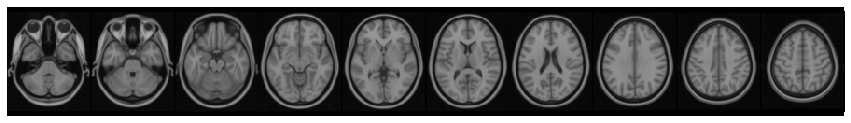

In [29]:
isc_r_brain.plot(cmap='heat')

/opt/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



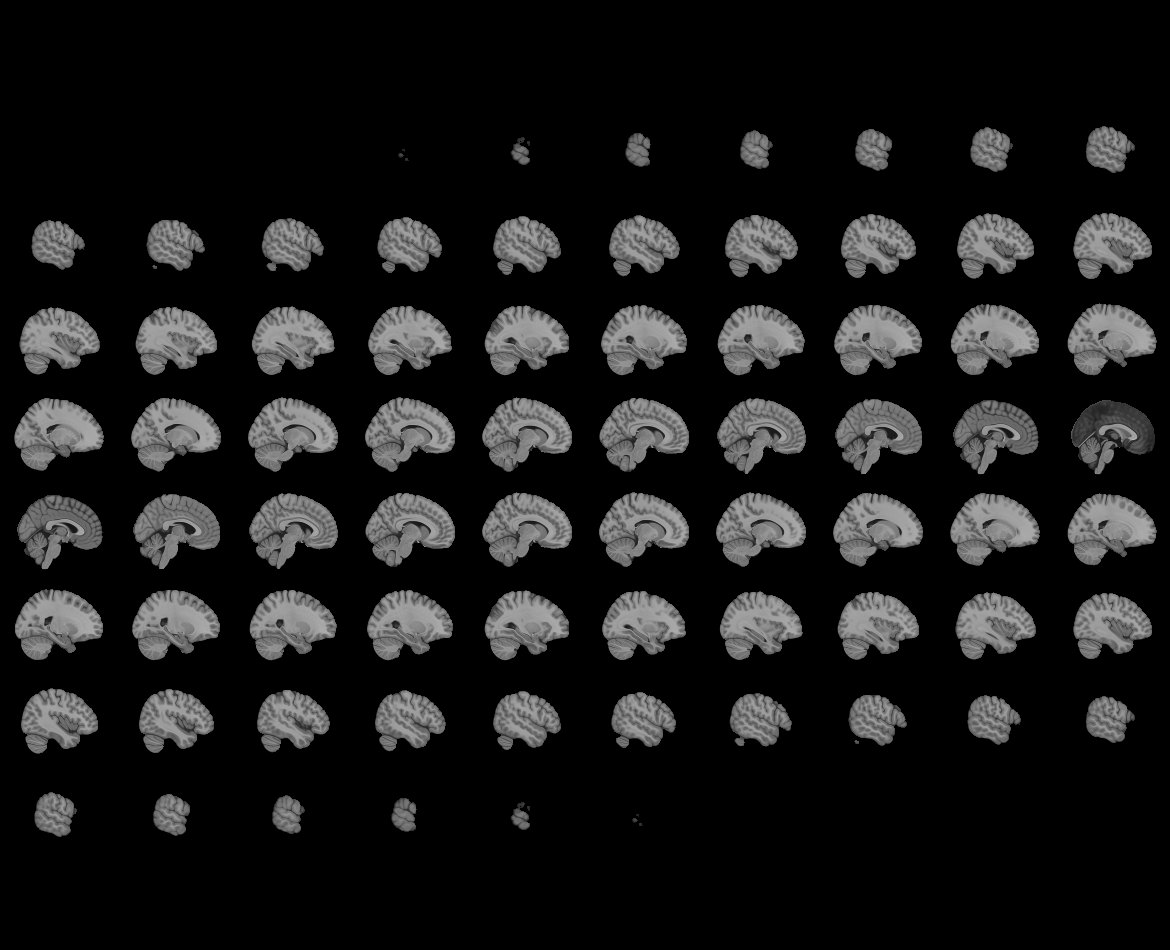
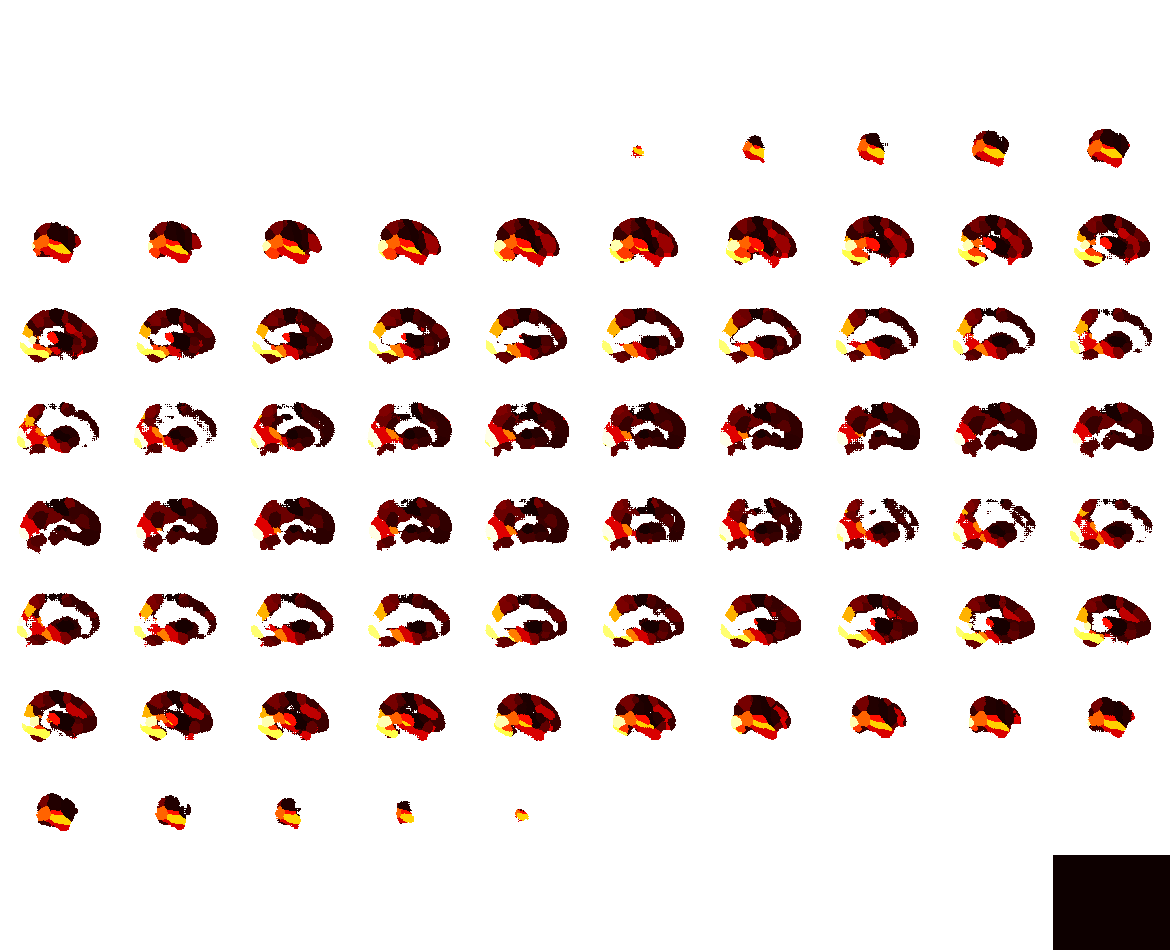

In [11]:
view_img(isc_r_brain.to_nifti())

Threshold the p-values using bonferroni correction (p < 0.001 for k=50 parcellation). Alternatively, use false discovery rate by setting 'thr=fdr(isc_p_brain.data)'

In [25]:
view_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti())

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [27]:
df = pd.DataFrame({'correlation': isc_r, 'p-val': isc_p})

df.to_csv('whole_brain_ISC.csv', index=False)
print(df)

    correlation     p-val
0      0.060918  0.000200
1      0.303567  0.000200
2      0.030655  0.000200
3      0.015006  0.001800
4      0.534677  0.000200
5      0.280727  0.000200
6      0.080625  0.000200
7      0.048773  0.000200
8      0.009020  0.004599
9      0.022625  0.000200
10     0.060119  0.000200
11     0.449901  0.000200
12     0.093801  0.000200
13     0.372855  0.000200
14     0.041758  0.000200
15     0.021056  0.000200
16     0.010277  0.001200
17     0.011705  0.000600
18     0.054230  0.000200
19     0.037416  0.000200
20     0.551501  0.000200
21     0.096645  0.000200
22     0.034785  0.000200
23     0.036766  0.000200
24     0.176189  0.000200
25     0.042282  0.000200
26     0.014961  0.001000
27     0.150447  0.000200
28     0.164534  0.000200
29     0.021748  0.000200
30     0.052186  0.000200
31     0.246151  0.000200
32     0.027772  0.000200
33     0.086993  0.000200
34     0.036436  0.000200
35     0.213655  0.000200
36     0.080256  0.000200
37     0.070

In [28]:
os.getcwd()

'/project/3013104.01/scripts'

Perform intersubject correlation analysis using the average activity timecourse of other subjects as a model for each individual subject, producing individual dataframes of similarity per subject.

Create a list of CSV files to analyze

In [118]:
# Directory path
directory = '/project/3013104.01/analysis/average_ROI_n50/appended_sessions'
os.chdir(directory)

# Pattern to match
pattern = 'subject-*'

# Find all CSV files in the directory that match the pattern
csv_files = glob.glob(pattern)

# Print the list of matching CSV files
for file in csv_files:
    print(file)

subject-0001_all_sessions.csv
subject-0002_all_sessions.csv
subject-0003_all_sessions.csv
subject-0004_all_sessions.csv
subject-0005_all_sessions.csv
subject-0006_all_sessions.csv
subject-0007_all_sessions.csv
subject-0008_all_sessions.csv
subject-0009_all_sessions.csv
subject-0010_all_sessions.csv
subject-0011_all_sessions.csv
subject-0012_all_sessions.csv
subject-0013_all_sessions.csv
subject-0014_all_sessions.csv
subject-0015_all_sessions.csv
subject-0016_all_sessions.csv
subject-0017_all_sessions.csv
subject-0018_all_sessions.csv
subject-0019_all_sessions.csv
subject-0020_all_sessions.csv
subject-0021_all_sessions.csv
subject-0022_all_sessions.csv
subject-0023_all_sessions.csv
subject-0024_all_sessions.csv
subject-0025_all_sessions.csv
subject-0026_all_sessions.csv
subject-0027_all_sessions.csv
subject-0028_all_sessions.csv
subject-0029_all_sessions.csv
subject-0030_all_sessions.csv
subject-0031_all_sessions.csv
subject-0032_all_sessions.csv
subject-0033_all_sessions.csv
subject-00

In [119]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# List the subjects and their corresponding CSV files
subjects = sub_list

# Load the data for each subject into a dictionary
subject_data = {}
for subject, csv_file in zip(subjects, csv_files):
    subject_data[subject] = pd.read_csv(csv_file)

# Get the number of regions-of-interest (columns)
n_roi = len(subject_data[subjects[0]].columns)

# Find the minimum number of voxels among all subjects
min_voxels = min(len(subject_data[subject]) for subject in subjects)

# Perform ISC for each subject using average activity timecourses of other subjects as a model for each individual subject and produce individual dataframes of similarity.
# Iterate over the regions-of-interest, only using the first 'min_voxels' rows of each subject's data to ensure consistency in voxel dimension
for target_subject in subjects:
    target_data = subject_data[target_subject][:min_voxels]
    model_data = np.mean([subject_data[subject][:min_voxels] for subject in subjects if subject != target_subject], axis=0)
    
    spatial_map = []
    for roi in range(n_roi):
        target_timecourse = target_data.iloc[:, roi].values
        model_timecourse = model_data[:, roi]
        
        correlation, _ = pearsonr(target_timecourse, model_timecourse)
        spatial_map.append(correlation)
    
    # Save the regions-of-interest ISC value for the target subject
    output_file = f"{target_subject}_ROI_ISC.csv"
    pd.DataFrame(spatial_map, columns=['Similarity']).to_csv(output_file, index=False)
    print(f"ROI ISC saved for {target_subject} as {output_file}.")

ROI ISC saved for subject-0001 as subject-0001_ROI_ISC.csv.
ROI ISC saved for subject-0002 as subject-0002_ROI_ISC.csv.
ROI ISC saved for subject-0003 as subject-0003_ROI_ISC.csv.
ROI ISC saved for subject-0004 as subject-0004_ROI_ISC.csv.
ROI ISC saved for subject-0005 as subject-0005_ROI_ISC.csv.
ROI ISC saved for subject-0006 as subject-0006_ROI_ISC.csv.
ROI ISC saved for subject-0007 as subject-0007_ROI_ISC.csv.
ROI ISC saved for subject-0008 as subject-0008_ROI_ISC.csv.
ROI ISC saved for subject-0009 as subject-0009_ROI_ISC.csv.
ROI ISC saved for subject-0010 as subject-0010_ROI_ISC.csv.
ROI ISC saved for subject-0011 as subject-0011_ROI_ISC.csv.
ROI ISC saved for subject-0012 as subject-0012_ROI_ISC.csv.
ROI ISC saved for subject-0013 as subject-0013_ROI_ISC.csv.
ROI ISC saved for subject-0014 as subject-0014_ROI_ISC.csv.
ROI ISC saved for subject-0015 as subject-0015_ROI_ISC.csv.
ROI ISC saved for subject-0016 as subject-0016_ROI_ISC.csv.
ROI ISC saved for subject-0017 as subjec

Prepare SPSQ questionnaire data: concatenate across subjects 

In [39]:
import os
import csv

subject_list = sub_list  
output_directory = "/project/3013104.01/analysis/isc"  
output_file = "SPSQ_all.csv"  

os.chdir ('/project/3013104.01/analysis')

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the full path of the output file
output_path = os.path.join(output_directory, output_file)

# Open the output file in append mode
with open(output_path, "a", newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    # Loop through each subject
    for subject in subject_list:
        subdir = os.path.join(subject, "sensory-processing_3")  
        file_path = os.path.join(subdir, "qst-post-3_SPS.csv")

        # Check if the file exists
        if os.path.isfile(file_path):
            # Open the CSV file
            with open(file_path, "r") as csv_file:
                reader = csv.reader(csv_file)
                
                # Get the first row (header) from the CSV file
                header = next(reader)
                
                # Only write the header for the first subject
                if subject == subject_list[0]:
                    writer.writerow(header)
                
                # Loop through each row in the CSV file
                for row in reader:
                    # Append the subject name to the beginning of the row
                    row.insert(0, subject)
                    
                    # Write the row to the output file
                    writer.writerow(row)


Removed items that were not in the SPSQ-24 short-form so that the items for this study match the items in the previous study, sorted the columns and re-calculated subscale totals

In [86]:
import csv
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('SPSQ-24_all.csv')

# Get the column names except for the first column
column_names = df.columns[1:]

# Sort the column names alphabetically
sorted_columns = sorted(column_names)

# Create a new DataFrame with sorted columns
sorted_df = df[['subject'] + sorted_columns]

# Write the sorted DataFrame back to a new CSV file
sorted_df.to_csv('SPSQ-24_all.csv', index=False)


Calculate average ISC value across all ROIs for each subject

In [121]:
import csv
import os

directory = '/project/3013104.01/analysis/isc'  
output_file = 'ISC_all.csv' 
os.chdir ('/project/3013104.01/analysis')

# Get all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Create the output file and write the header
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File', 'Column', 'Average'])

    # Iterate over each CSV file
    for file in csv_files:
        with open(os.path.join(directory, file), 'r') as csv_file:
            reader = csv.reader(csv_file)
            rows = list(reader)

            # Check if the CSV file has at least one row (excluding the header)
            if len(rows) > 1:
                # Extract the header and data rows
                header = rows[0]
                data = rows[1:]

                # Calculate the average for each column
                num_columns = len(header)

                for i in range(num_columns):
                    column_values = [float(row[i]) for row in data if row[i]]  # Skip empty cells
                    avg = sum(column_values) / len(column_values)
                    writer.writerow([file, header[i], avg])
            else:
                print(f"Skipping file '{file}' as it doesn't have enough rows.")

Merge ISC_avg and SPSQ dataframes

In [122]:
os.chdir ('/project/3013104.01/analysis')

# Read the CSV files
df1 = pd.read_csv('ISCavg_all.csv')
df2 = pd.read_csv('SPSQ-24_all.csv')

# Merge the files based on a common column
merged_df = pd.merge(df1, df2, on='subject')

# Save the merged data to a new CSV file
merged_df.to_csv('ISC_SPSQ_merged.csv', index=False)

In [123]:
# Combine subject-specific ROI ISC .csv files

import os
import pandas as pd

os.chdir ('/project/3013104.01/analysis')

# Directory paths
input_directory = '/project/3013104.01/analysis/isc'
output_directory = '/project/3013104.01/analysis'

# List of subjects
subject_list = sub_list

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over the subject list
for subject in subject_list:
    # Read the subject's CSV file
    subject_csv_path = os.path.join(input_directory, f'{subject}_ROI_ISC.csv')
    subject_data = pd.read_csv(subject_csv_path)
    
    # Set the subject name as the new header
    subject_data.columns = [subject]
    
    # Concatenate the subject's data horizontally
    combined_data = pd.concat([combined_data, subject_data], axis=1)

# Transpose the combined data
transposed_data = combined_data.transpose()

# Add the subject name as a separate column
transposed_data['subject'] = transposed_data.index

# Reset the index to integer values
transposed_data.reset_index(drop=True, inplace=True)

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Write the transposed data to a new CSV file in the output directory
output_path = os.path.join(output_directory, 'combined_ISC_data.csv')
transposed_data.to_csv(output_path, index=False)

In [124]:
# Merge data containing SPS scores, whole-brain ISC, and ROI-specific ISC

os.chdir ('/project/3013104.01/analysis')

# Read the CSV files
df1 = pd.read_csv('ISC_SPSQ_merged.csv')
df2 = pd.read_csv('combined_ISC_data.csv')

# Merge the files based on a common column
merged_df = pd.merge(df1, df2, on='subject')

# Save the merged data to a new CSV file
merged_df.to_csv('ISC_SPSQ_merged.csv', index=False)

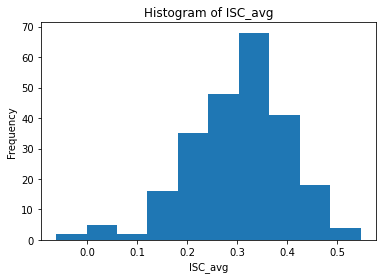

In [125]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('ISC_SPSQ_merged.csv')

# Specify the column to create a histogram for
column_name = 'ISC_avg'

# Create the histogram
plt.hist(df[column_name], bins=10)  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_name))

# Display the histogram
plt.show()


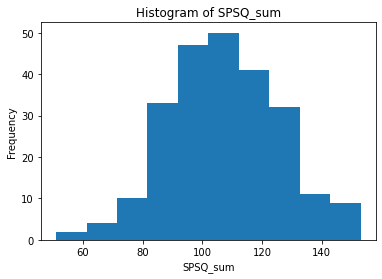

In [126]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('ISC_SPSQ_merged.csv')

# Specify the column to create a histogram for
column_name = 'SPSQ_sum'

# Create the histogram
plt.hist(df[column_name], bins=10)  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_name))

# Display the histogram
plt.show()


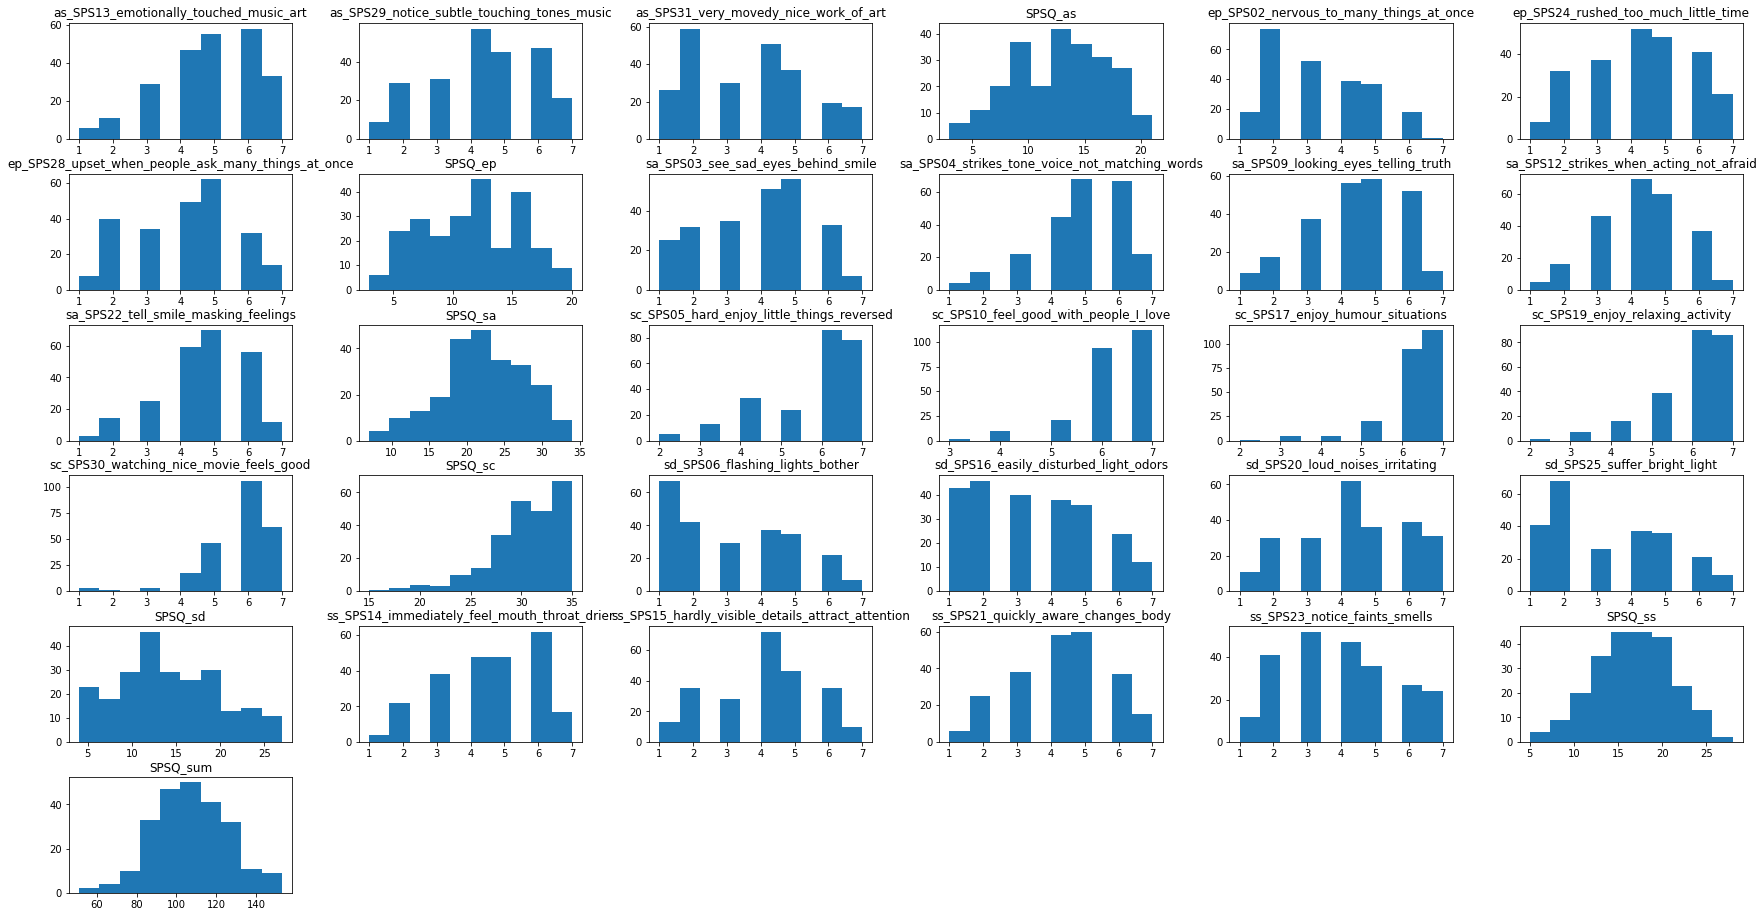

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('ISC_SPSQ_merged.csv')

# Select columns that begin with "SPS"
columns_to_plot = [col for col in data.columns if 'SPS' in col]

# Plot histograms
data[columns_to_plot].hist(bins=10, figsize=(30, 16), grid=False)

# Display the plot
plt.show()


Create a correlation network plot of columns with headers with "SPS"

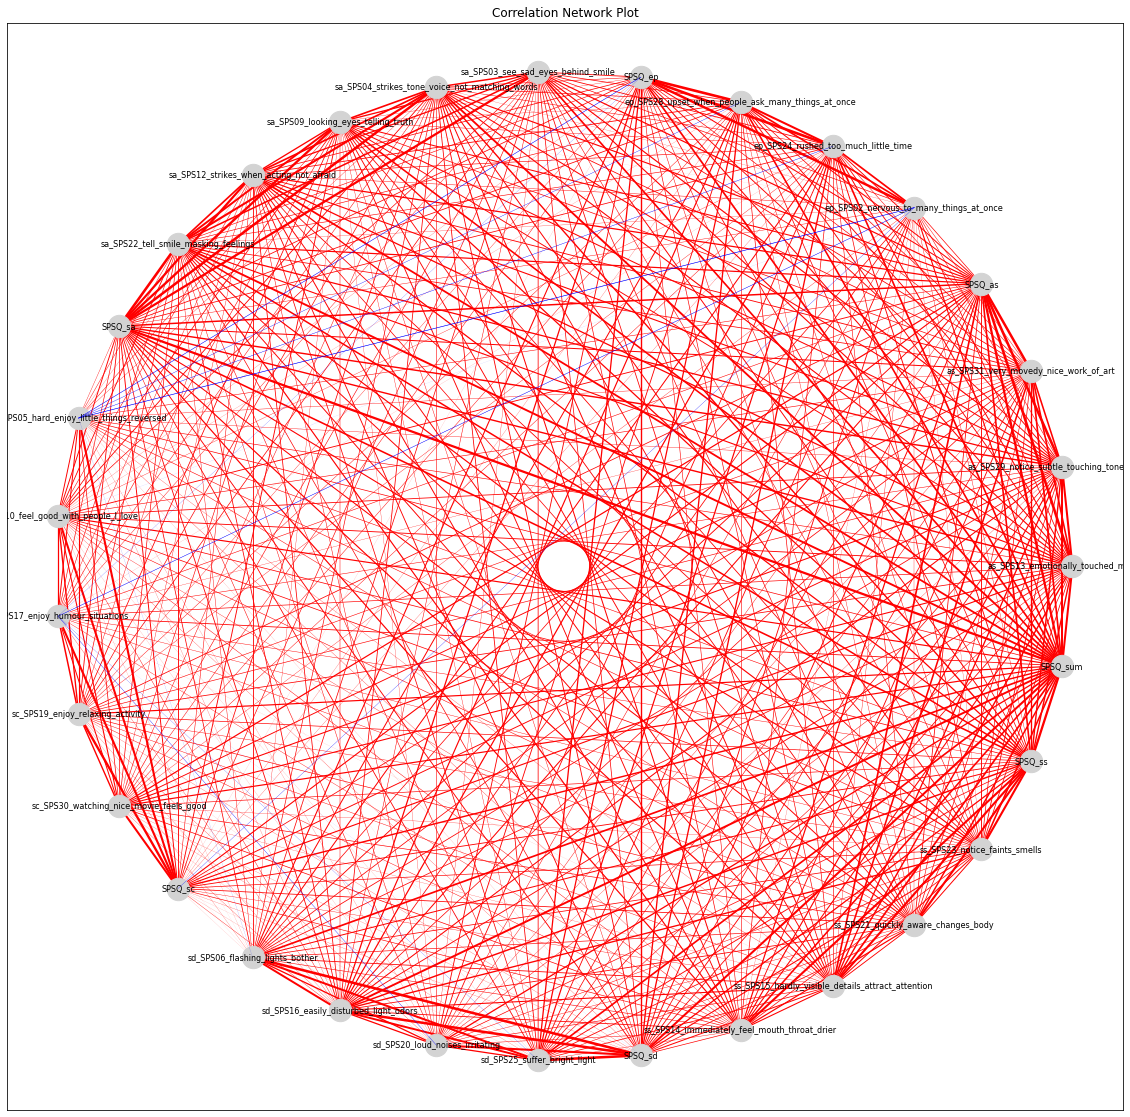

In [94]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

df = pd.read_csv('ISC_SPSQ_merged.csv')

# Select columns starting with "SPS"
sps_columns = [col for col in df.columns if 'SPS' in col]

# Create a correlation matrix for the selected columns
corr_matrix = df[sps_columns].corr()

# Create a graph object
graph = nx.from_pandas_adjacency(corr_matrix)

# Set node labels as column names
node_labels = {i: col for i, col in enumerate(sps_columns)}
graph = nx.relabel_nodes(graph, node_labels)

# Set edge widths based on correlation values
edge_widths = [corr_matrix[u][v] * 3 for u, v, d in graph.edges(data=True)]

# Set edge colors based on positive or negative correlation
edge_colors = ['red' if d['weight'] > 0 else 'blue' for u, v, d in graph.edges(data=True)]

# Set the figure size
plt.figure(figsize=(20, 20))

# Draw the nodes
pos = nx.circular_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_color='lightgray', node_size=500)

# Draw the edges with custom colors
for (u, v, d), color, width in zip(graph.edges(data=True), edge_colors, edge_widths):
    if color == 'blue':
        line = plt.Line2D([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], color=color, linewidth=width)
        line.set_path_effects([pe.Stroke(linewidth=width * 0.2), pe.Normal()])
        plt.gca().add_line(line)
    else:
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=width, edge_color=color)

# Draw the node labels
nx.draw_networkx_labels(graph, pos, font_size=8)

plt.title('Correlation Network Plot')
plt.show()

Standardize all data (except for subject ID, of course)

In [128]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the input CSV file
input_file = 'ISC_SPSQ_merged.csv'
df = pd.read_csv(input_file)

# Extract the first column (non-numeric)
first_column = df.iloc[:, 0]

# Standardize remaining columns
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df.iloc[:, 1:])

# Combine the standardized values with the first column
df_standardized = pd.DataFrame(scaled_values, columns=df.columns[1:])
df_standardized.insert(0, df.columns[0], first_column)

# Save the standardized data to a new CSV file
output_file = 'ISC_SPSQ_merged_standardized.csv'
df_standardized.to_csv(output_file, index=False)

Calculate the association between whole-brain ISC and SPS

In [129]:
import pandas as pd
from scipy.stats import pearsonr

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('ISC_SPSQ_merged_standardized.csv')

# Extract the two columns of interest
column1 = data['ISC_avg']
column2 = data['SPSQ_sum']

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(column1, column2)

# Print the results
print("Pearson correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)


Pearson correlation coefficient: 0.07134079160696559
p-value: 0.27197752173481776


Therefore, there is no evidence of an association between whole-brain intersubject correlation and sensory processing sensitivity. The association was very small and positive: More ISC related to higher SPS, but this was not significant.

Model the interaction in a GLM between ISC as the dependent variable, SPS as the independent variable, and ROI as the moderating variable

In [29]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

Prepare data:
Create a DataFrame containing variables (ISC, SPS, ROI).
Ensure that all variables are numeric.
Fit the GLM with the interaction term:

In [162]:
os.chdir ('/project/3013104.01/analysis')

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('ISC_SPSQ_merged_standardized.csv')

# Print column names with column numbers
for i, col in enumerate(data.columns):
    print(f"Column {i+1}: {col}")

Column 1: subject
Column 2: ISC_avg
Column 3: as_SPS13_emotionally_touched_music_art
Column 4: as_SPS29_notice_subtle_touching_tones_music
Column 5: as_SPS31_very_movedy_nice_work_of_art
Column 6: SPSQ_as
Column 7: ep_SPS02_nervous_to_many_things_at_once
Column 8: ep_SPS24_rushed_too_much_little_time
Column 9: ep_SPS28_upset_when_people_ask_many_things_at_once
Column 10: SPSQ_ep
Column 11: sa_SPS03_see_sad_eyes_behind_smile
Column 12: sa_SPS04_strikes_tone_voice_not_matching_words
Column 13: sa_SPS09_looking_eyes_telling_truth
Column 14: sa_SPS12_strikes_when_acting_not_afraid
Column 15: sa_SPS22_tell_smile_masking_feelings
Column 16: SPSQ_sa
Column 17: sc_SPS05_hard_enjoy_little_things_reversed
Column 18: sc_SPS10_feel_good_with_people_I_love
Column 19: sc_SPS17_enjoy_humour_situations
Column 20: sc_SPS19_enjoy_relaxing_activity
Column 21: sc_SPS30_watching_nice_movie_feels_good
Column 22: SPSQ_sc
Column 23: sd_SPS06_flashing_lights_bother
Column 24: sd_SPS16_easily_disturbed_light_od

In [163]:
# Get the column names to use as var_name
value_vars = data.columns[33:]

# Melt the data frame into long format
data_melt = pd.melt(data, id_vars=['subject', 'ISC_avg', 'SPSQ_sum'], value_vars = value_vars, var_name = 'ROI', value_name='ISC_ROI')
print("\nMelted data frame:")
print(data_melt)


Melted data frame:
            subject   ISC_avg  SPSQ_sum     ROI   ISC_ROI
0      subject-0001  0.454922 -1.543056   ROI_0 -0.080112
1      subject-0002 -3.077969 -0.621893   ROI_0 -0.958718
2      subject-0003  0.080982  0.949503   ROI_0 -0.709696
3      subject-0004 -1.260877 -0.242590   ROI_0  0.370424
4      subject-0005  0.201718  0.841131   ROI_0  0.927003
...             ...       ...       ...     ...       ...
11945  subject-0235  0.027578 -0.296776  ROI_49  0.109635
11946  subject-0236 -0.032558  1.220434  ROI_49  0.472460
11947  subject-0237 -0.049503  0.082526  ROI_49 -0.016316
11948  subject-0238  1.574636  0.028340  ROI_49 -0.322724
11949  subject-0239  0.008829  0.353456  ROI_49 -0.705370

[11950 rows x 5 columns]


In [164]:
data_melt['ROI'] = data_melt['ROI'].astype('category')

# Model interaction: 
# The formula parameter specifies the formula for the model, including the dependent variable (ISC), independent variable (SPS), and moderating variable (ROI).
# SPS * ROI indicates the interaction term between SPS and ROI.
# family=sm.families.Gaussian() specifies that we assume a Gaussian distribution for the dependent variable.
model = smf.glm(formula='ISC_avg ~ SPSQ_sum + ISC_ROI + SPSQ_sum:ISC_ROI', data=data_melt, family=sm.families.Gaussian()).fit()

# View the model summary:
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ISC_avg   No. Observations:                11950
Model:                            GLM   Df Residuals:                    11946
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.76270
Method:                          IRLS   Log-Likelihood:                -15336.
Date:                Wed, 28 Jun 2023   Deviance:                       9111.2
Time:                        17:14:51   Pearson chi2:                 9.11e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4.035e-06      0.008  

In the association between whole-brain ISC and SPS, the interaction between SPS and region-specific ISC is not significant. 

Calculate correlation between the average ISC in each ROI and SPS

In [159]:
import pandas as pd
from scipy.stats import pearsonr

# Read the CSV file
data = pd.read_csv('ISC_SPSQ_merged_standardized.csv')

# Select the ROI columns
roi_columns = data.iloc[:, 33:]

# Create a list to store the results
results = []

# Perform Pearson correlation and calculate p-value for each ROI and SPS
for roi_col in roi_columns:
    # Drop rows with missing values
    valid_data = data.dropna(subset=[roi_col, 'SPSQ_sum'])
    
    # Perform Pearson correlation and calculate p-value
    correlation, p_value = pearsonr(valid_data[roi_col], valid_data['SPSQ_sum'])
    
    # Store the results in a dictionary
    result = {'roi_col': roi_col, 'correlation': correlation, 'p_value': p_value}
    
    # Append the result to the list
    results.append(result)

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file with headers
result_df.to_csv('correlation_ROI-ISC_SPSQ.csv', index=False)

Correct p-values for multiple testing across 50 ROIs in each subject

In [160]:
import pandas as pd
import statsmodels.stats.multitest as smt

# Read the CSV file
data = pd.read_csv('correlation_ROI-ISC_SPSQ.csv')

# Assuming the p-values are in a column named 'p_values'
p_values = data['p_value']

# Perform FDR correction
corrected_p_values = smt.multipletests(p_values, method='fdr_bh')[1]

# Add the corrected p-values as a new column
data['p_fdr'] = corrected_p_values

# Save the modified DataFrame to a new CSV file
data.to_csv('correlation_ROI-ISC_SPSQ.csv', index=False)


ROI 8, the supplementary motor area (SMA), has a p_fdr=0.0300372023554225 and r=-0.220027937949368
ROI 28, the hippocampus, has a p_fdr=0.036307143217863 and r=0.204476263675127

/opt/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/2021.05/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


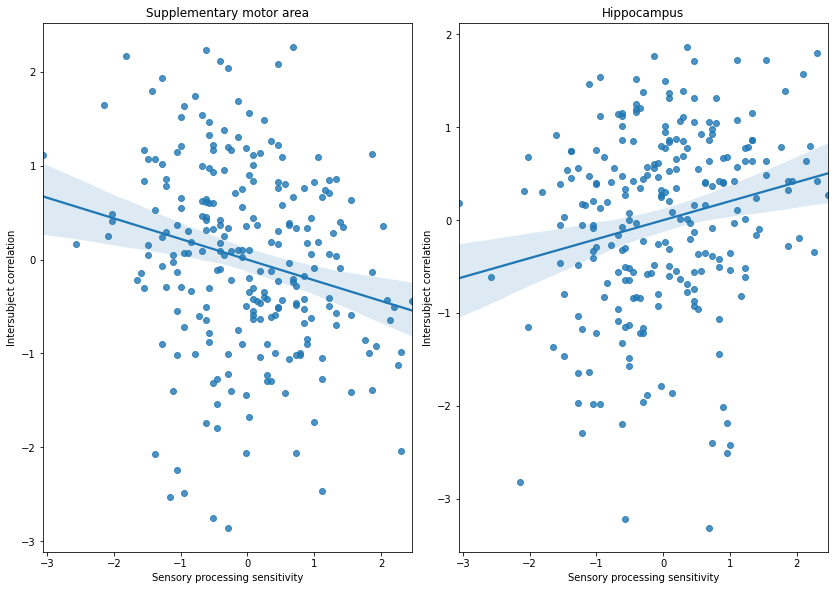

In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('ISC_SPSQ_merged_standardized.csv')

# Extract the columns of interest
x = data['SPSQ_sum']
y1 = data['8'] 
y2 = data['28']  # hippocampus

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.7, 8.3))  # A4 landscape size

# Plot the first scatter plot
sns.regplot(x, y1, ax=ax1)
ax1.set_xlabel('Sensory processing sensitivity')
ax1.set_ylabel('Intersubject correlation')
ax1.set_title('Supplementary motor area')

# Plot the second scatter plot
sns.regplot(x, y2, ax=ax2)
ax2.set_xlabel('Sensory processing sensitivity')
ax2.set_ylabel('Intersubject correlation')
ax2.set_title('Hippocampus')

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots as a PDF file
plt.savefig('correlation_ROI-ISC_SPS.pdf', format='pdf', orientation='landscape')

# Display the plots
plt.show()

In [14]:
# calculate mean activation in the SMA and the HPC for each subject

import os
import pandas as pd

# Directory path where the CSV files are located
directory = "/project/3013104.01/analysis/average_ROI_n50/appended_sessions/"
os.chdir('/project/3013104.01/analysis/')

# List of subjects
subjects = sub_list

# Output file name
output_file = "mean_activation_roi_8_sma.csv"

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=["subject", "mean_activation"])

# Iterate over the subjects
for subject in subjects:
    # Find the CSV files with the subject name in the directory
    csv_files = [filename for filename in os.listdir(directory) if subject in filename and filename.endswith(".csv")]
    
    # Iterate over the found CSV files
    for csv_file in csv_files:
        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, csv_file))
        
        # Calculate the average of column "8"
        average = df["8"].mean()
        
        # Append the results to the DataFrame
        results = results.append({"subject": subject, "mean_activation": average}, ignore_index=True)

# Save the results to a new CSV file
results.to_csv(output_file, index=False)


In [20]:
# merge with SPS data
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the first CSV file
df1 = pd.read_csv('mean_activation_roi_28_hpc.csv')

# Read the second CSV file with the two columns to merge
df2 = pd.read_csv('SPSQ-24_all.csv', usecols=['subject', 'SPSQ_sum'])

# Merge the dataframes based on the 'subject' column
merged_df = pd.merge(df1, df2, on='subject', how='inner')

# Select the columns to standardize (except the first column)
columns_to_standardize = merged_df.columns[1:]

# Create a StandardScaler object and fit_transform the selected columns
scaler = StandardScaler()
merged_df[columns_to_standardize] = scaler.fit_transform(merged_df[columns_to_standardize])

# Save the merged dataframe to a new CSV file
merged_df.to_csv('mean_activation_roi_28_hpc.csv', index=False)


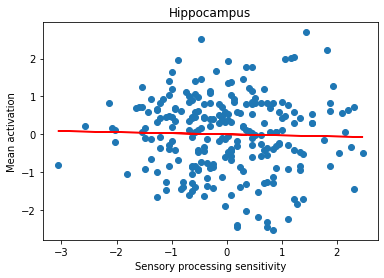

Correlation value: -0.03
P-value: 0.66


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('mean_activation_roi_28_hpc.csv')

# Extract the x and y columns from the DataFrame
x = data['SPSQ_sum']
y = data['mean_activation']

# Create a scatter plot of x against y
plt.scatter(x, y)

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
regression_line = slope * x + intercept

# Add the regression line to the plot
plt.plot(x, regression_line, color='red')

# Set the labels and title of the plot
plt.xlabel('Sensory processing sensitivity')
plt.ylabel('Mean activation')
plt.title('Hippocampus')

# Display the plot
plt.show()

# Print correlation value and p-value
print(f"Correlation value: {r_value:.2f}")
print(f"P-value: {p_value:.2f}")


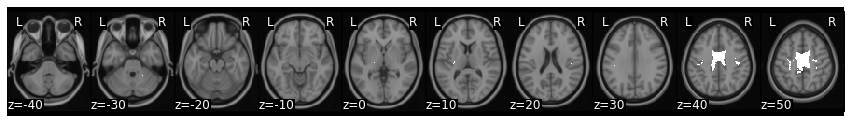

In [6]:
mask_x[8].plot()

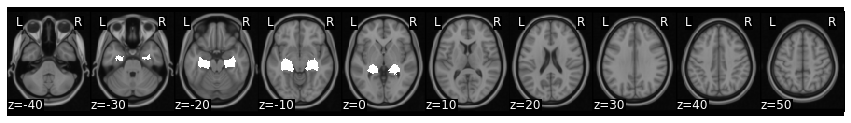

In [7]:
mask_x[28].plot()